# P4 Milestone  
## Predicting whether and when a betrayal will occur and based on linguistic features

Import and load data

In [60]:
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from io import open
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor,MLPClassifier

# load the data
with open("diplomacy_data.json", "r") as f:
    diplomacy = json.load(f)

diplomacy_original = diplomacy

### Data Preprocessing
After loading the data, we delete the messages which has 0 sentences (obviously these messages do not make sense).  
Besides, we keep only the seasons when both betrayers and victims send messages to each other, so that we could calculate their imbanlance

In [61]:
# data preprocessing

# keep only the seasons when both players send messages
for game in diplomacy:
    for season in reversed(game['seasons']):
        if not (len(season['messages']['betrayer']) > 0 and len(season['messages']['victim']) > 0):
            del game['seasons'][game['seasons'].index(season)]

# delete messages in which the number of sentences is 0 (meaningless)
for game in diplomacy:
    for season in game['seasons']:
        for betray_msg in reversed(season['messages']['betrayer']):
            if betray_msg['n_sentences'] == 0:
                del season['messages']['betrayer'][(season['messages']['betrayer'].index(betray_msg))]

### Model I: Predicting whether the game would end with betrayal

First, obtain the features of each game in the data


In [62]:
# this cell considers games as classification instances

# intializae the features (according to Table 2 of the given paper)
be_po_sentiment = []
be_ne_sentiment = []
be_n_sentences = []
be_n_expansion = []
be_n_comparison = []
be_n_contingency = []
be_n_words = []
be_n_plan = []

betrayal_bool = []   # 1 if betrayal, 0 if friendship

game_index = []      # the index of game

# get the features and labels for each game
for game in diplomacy:
    be_po_sentiment_this_game = []
    be_ne_sentiment_this_game = []
    be_n_sentences_this_game = []
    be_n_expansion_this_game = []
    be_n_comparison_this_game = []
    be_n_contingency_this_game = []
    be_n_words_this_game = []
    be_n_plan_this_game = []
    
    for season in game['seasons']:
            be_po_sentiment_this_game.append(sum((msg['sentiment']['positive']/msg['n_sentences']) for msg in season['messages']['betrayer'])/ len(season['messages']['betrayer']))
            be_ne_sentiment_this_game.append(sum((msg['sentiment']['negative']/msg['n_sentences']) for msg in season['messages']['betrayer'])/ len(season['messages']['betrayer']))
            be_n_sentences_this_game.append(sum(msg['n_sentences'] for msg in season['messages']['betrayer'])/ len(season['messages']['betrayer']))
            be_n_words_this_game.append(sum(msg['n_words'] for msg in season['messages']['betrayer'])/ len(season['messages']['betrayer']))
            be_n_expansion_this_season = []
            be_n_comparison_this_season = []
            be_n_contingency_this_season = []
            be_n_plan_this_season = []
            for msg in season['messages']['betrayer']:
                if 'disc_expansion' in msg['lexicon_words']:
                    be_n_expansion_this_season.append(len(msg['lexicon_words']['disc_expansion']))
                else:
                    be_n_expansion_this_season.append(0)
                if 'disc_comparison' in msg['lexicon_words']:
                    be_n_comparison_this_season.append(len(msg['lexicon_words']['disc_comparison']))
                else:
                    be_n_comparison_this_season.append(0)
                if 'disc_contingency' in msg['lexicon_words']:
                    be_n_contingency_this_season.append(len(msg['lexicon_words']['disc_contingency']))
                else:
                    be_n_contingency_this_season.append(0)
                if 'disc_temporal_future' in msg['lexicon_words']:
                    be_n_plan_this_season.append(len(msg['lexicon_words']['disc_temporal_future']))
                else:
                    be_n_plan_this_season.append(0)
            be_n_expansion_this_game.append(sum(be_n_expansion_this_season)/len(season['messages']['betrayer']))
            be_n_comparison_this_game.append(sum(be_n_comparison_this_season)/len(season['messages']['betrayer']))
            be_n_contingency_this_game.append(sum(be_n_contingency_this_season)/len(season['messages']['betrayer']))
            be_n_plan_this_game.append(sum(be_n_plan_this_season)/len(season['messages']['betrayer']))
            
    be_po_sentiment.append(np.mean(be_po_sentiment_this_game))
    be_ne_sentiment.append(np.mean(be_ne_sentiment_this_game))
    be_n_sentences.append(np.mean(be_n_sentences_this_game))
    be_n_expansion.append(np.mean(be_n_expansion_this_season))
    be_n_comparison.append(np.mean(be_n_comparison_this_season))
    be_n_contingency.append(np.mean(be_n_contingency_this_season))
    be_n_words.append(np.mean(be_n_words_this_game))
    be_n_plan.append(np.mean(be_n_plan_this_season))
    betrayal_bool.append(1 if game['betrayal'] == True else 0)
    game_index.append(game['idx'])

D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Store the features and labels in the DataFrame. Split the training set and test set, according to randomly shuffled game indexes

In [63]:
# store the features and labels in the dataframe
data = pd.DataFrame({'be_po_sentiment':be_po_sentiment, 'be_ne_sentiment':be_ne_sentiment,'be_n_sentences':be_n_sentences,
                     'be_n_expansion':be_n_expansion, 'be_n_comparison':be_n_comparison, 'be_n_contingency':be_n_contingency,
                     'be_n_words':be_n_words, 'be_n_plan':be_n_plan, 'betrayal_label':betrayal_bool, 'game_index': game_index})

data = data.dropna(axis=0, how='any')     # drop the data with 'na'
data.index = range(len(data))           # re-index the dataframe

# feature normalization
feature_columns_1 = ['be_po_sentiment', 'be_ne_sentiment', 'be_n_sentences','be_n_expansion','be_n_comparison','be_n_contingency','be_n_words','be_n_plan']
features_std = pd.DataFrame()
for feature in feature_columns_1:
    features_std[feature] = (data[feature] - data.mean()[feature]) / data.std()[feature]
    data[feature] = features_std[feature]

# labels
label_columns_1 = ['game_index', 'betrayal_label']
labels = data[label_columns_1]

np.random.seed(0)
random_game = np.random.permutation(data.game_index)              # randomly shuffle the game indexes
random_game_train = random_game[0:int(len(data.game_index)*0.8)]  # choose the first 80% of the random game indexes as indexes for training set
random_game_test = random_game[int(len(data.game_index)*0.8):]    # choose the last 20% of the random game indexes as indexes for test set


train_features_std_1 = data[data.loc[:, 'game_index'].isin(random_game_train)][feature_columns_1] # training set
test_features_std_1 = data[data.loc[:, 'game_index'].isin(random_game_test)][feature_columns_1]   # test set 

train_labels_1 = data[data.loc[:, 'game_index'].isin(random_game_train)][label_columns_1] 
test_labels_1 = data[data.loc[:, 'game_index'].isin(random_game_test)][label_columns_1]  

This cell draws the figure for the comparison of the min-max normalized features for the games ending with betrayal and friendships (Figure 2 in the report)

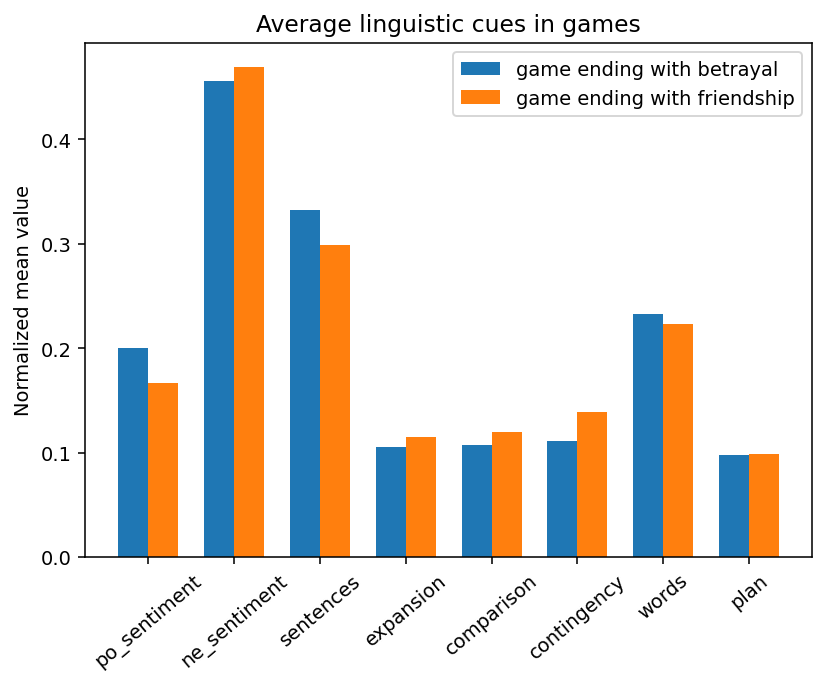

In [48]:
# This part is to draw the difference of Average linguistic cues in games

data1 = pd.DataFrame({'be_po_sentiment':be_po_sentiment, 'be_ne_sentiment':be_ne_sentiment,'be_n_sentences':be_n_sentences,
                     'be_n_expansion':be_n_expansion, 'be_n_comparison':be_n_comparison, 'be_n_contingency':be_n_contingency,
                     'be_n_words':be_n_words, 'be_n_plan':be_n_plan, 'label':betrayal_bool, 'game_index': game_index})

data1 = data1.dropna(axis=0, how='any')     # drop the data with 'na'
data1.index = range(len(data1))           # re-index the dataframe

# min_max feature normalization
feature_columns_1_1 = ['be_po_sentiment', 'be_ne_sentiment', 'be_n_sentences','be_n_expansion','be_n_comparison','be_n_contingency','be_n_words','be_n_plan']
features_std_1 = pd.DataFrame()
for feature in feature_columns_1_1:
    features_std_1[feature] = (data1[feature] - data1.min()[feature]) / (data1.max()[feature]-data1.min()[feature])
    data1[feature] = features_std_1[feature]

data1[data1['label'] == 1].mean() - data1[data1['label'] == 0].mean()
be = data1[data1['label'] == 1].mean()
vi = data1[data1['label'] == 0].mean()

labels = ['po_sentiment', 'ne_sentiment', 'sentences', 'expansion', 'comparison',
          'contingency','words','plan']
be_means = be.tolist()[0:8]
vi_means = vi.tolist()[0:8]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 5),dpi= 140)
#plt.figure(figsize=(10, 6),dpi= 200)
rects1 = ax.bar(x - width/2, be_means, width, label='game ending with betrayal')
rects2 = ax.bar(x + width/2,vi_means, width, label='game ending with friendship')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalized mean value')
ax.set_title('Average linguistic cues in games')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=40)
fig.tight_layout()

plt.savefig('1')
plt.show()

Do 5-fold cross validation in the training set for 100 times, comparing three algorithms: Linear Regression, Gradient Boost Regressor, and Neural Network, and report the mean and confidence intervals of accuracy and Matthews coefficient

In [43]:
# 5-fold crossvalidation function
def cross_validation(x,y,model):
    x.index = range(len(x))
    y.index = range(len(y))
    kf = KFold(n_splits=5,shuffle=True)
    vali_correct_rate = []
    tr_correct_rate = []
    ma_coef = []
    for train_index , vali_index in kf.split(x):
        model.fit(x.loc[train_index], y.loc[train_index]) # fit model"
        pred_tr = model.predict(x.loc[train_index])
        pred_tr = (pred_tr>=0.5)+0
        pred_vali = model.predict(x.loc[vali_index])
        pred_vali = (pred_vali>=0.5)+0
        tr_correct_rate_tmp =np.mean(pred_tr == y.loc[train_index])
        tr_correct_rate.append(tr_correct_rate_tmp)
        vali_correct_rate_tmp =np.mean(pred_vali == y.loc[vali_index])
        ma_coef_tmp = matthews_corrcoef(y.loc[vali_index],pred_vali)
        ma_coef.append(ma_coef_tmp)
        vali_correct_rate.append(vali_correct_rate_tmp)
    return np.mean(vali_correct_rate),np.mean(ma_coef)

model1 = LinearRegression() # use linear regression model
model2 = GradientBoostingRegressor()
model3 = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(10,10,5,5), random_state=1,max_iter=5000,learning_rate_init=0.001)


cv_accuracy_model = []
cv_Matthews_model = []
cv_5_percentile_model = []
cv_95_percentile_model = []
mc_5_percentile_model = []
mc_95_percentile_model = []
for model in [model1,model2,model3]:
    cv_accuracy = []
    cv_Matthews = []
    for i in range(100):
        accuracy, Matthews = cross_validation( train_features_std_1, train_labels_1.betrayal_label, model)
        cv_accuracy.append(accuracy)
        cv_Matthews.append(Matthews)
        if (i%10) == 0:
            print("Finished:" + str(i) + "/100")
    print(str(model)+"\nMean cross validation accuracy over 100 times :" + str(np.mean(cv_accuracy)))
    print(str(model)+"\nMean cross validation Matthews coefficient over 100 times :" + str(np.mean(cv_Matthews)))
    cv_accuracy_model.append(np.mean(cv_accuracy))
    cv_Matthews_model.append(np.mean(cv_Matthews))
    print("Confidence interval for accuracy, with 90 bootstrap confidence: " + str([np.nanpercentile(cv_accuracy, 5), np.nanpercentile(cv_accuracy, 95)]))
    print("Confidence interval for Matthews coefficient, with 90 bootstrap confidence: " + str([np.nanpercentile(cv_Matthews, 5), np.nanpercentile(cv_Matthews, 95)]))
    cv_5_percentile_model.append(np.nanpercentile(cv_accuracy, 5))
    cv_95_percentile_model.append(np.nanpercentile(cv_accuracy, 95))
    mc_5_percentile_model.append(np.nanpercentile(cv_Matthews, 5))
    mc_95_percentile_model.append(np.nanpercentile(cv_Matthews, 95))
    print('\n')

Finished:0/100
Finished:10/100
Finished:20/100
Finished:30/100
Finished:40/100
Finished:50/100
Finished:60/100
Finished:70/100
Finished:80/100
Finished:90/100
LinearRegression()
Mean cross validation accuracy over 100 times :0.5611803278688524
LinearRegression()
Mean cross validation Matthews coefficient over 100 times :0.13437151319793733
Confidence interval for accuracy, with 90 bootstrap confidence: [0.5344262295081967, 0.5870491803278689]
Confidence interval for Matthews coefficient, with 90 bootstrap confidence: [0.08592357368112613, 0.18843707853668626]


Finished:0/100
Finished:10/100
Finished:20/100
Finished:30/100
Finished:40/100
Finished:50/100
Finished:60/100
Finished:70/100
Finished:80/100
Finished:90/100
GradientBoostingRegressor()
Mean cross validation accuracy over 100 times :0.5792459016393442
GradientBoostingRegressor()
Mean cross validation Matthews coefficient over 100 times :0.16432853369640343
Confidence interval for accuracy, with 90 bootstrap confidence: [0.55065

Comparison of the three algorithms in terms of validation results of mean accuracy and Matthews coefficient

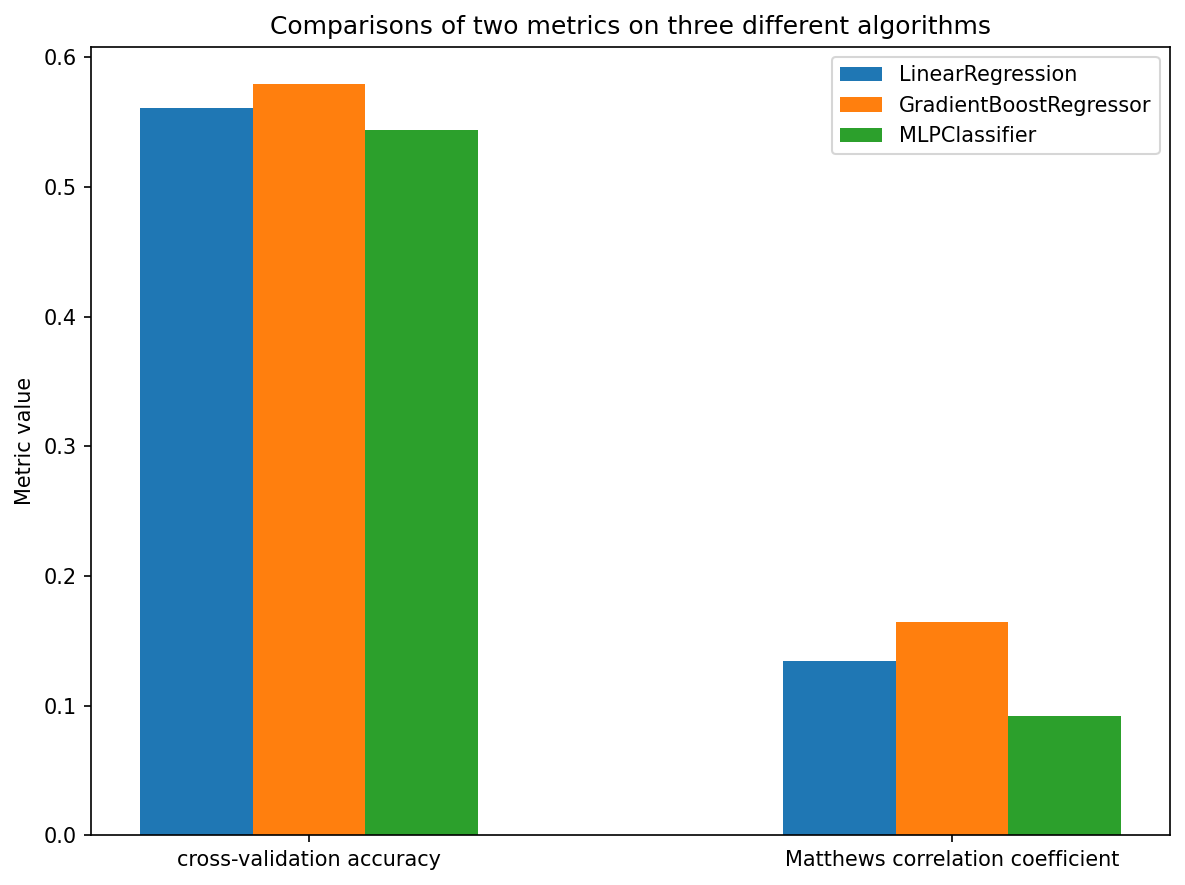

In [64]:
cv_bootstrap_confidence = [cv_95_percentile_model[i]-cv_5_percentile_model[i] for i in range(len(cv_95_percentile_model))]
mc_bootstrap_confidence = [mc_95_percentile_model[i]-mc_5_percentile_model[i] for i in range(len(mc_95_percentile_model))]
# This part is to draw the cross validation accuracy and Matthews coefficient for linear, GradientBoostingRegressor,  MLPClassifier
labels = ['cross-validation accuracy', 'Matthews correlation coefficient', ]
LinearRegression_r = [cv_accuracy_model[0], cv_Matthews_model[0]]
GradientBoostingRegressor_r = [cv_accuracy_model[1], cv_Matthews_model[1]]
MLPClassifier_r = [cv_accuracy_model[2], cv_Matthews_model[2]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6),dpi= 150)
rects1 = ax.bar(x - width/2,
                LinearRegression_r,
                width = width/2, 
                capsize=3,
                label='LinearRegression')
rects2 = ax.bar(x , 
                GradientBoostingRegressor_r, 
                width = width/2, 
                capsize=3,
                label='GradientBoostRegressor')
rects3 = ax.bar(x + width/2 , 
                MLPClassifier_r,
                width = width/2 ,
                capsize=3,
                label='MLPClassifier')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric value')
ax.set_title('Comparisons of two metrics on three different algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')
# autolabel(rects1)
# autolabel(rects2)
# autolabel(rects3)
# ax2 = ax.twinx()


fig.tight_layout()
plt.savefig('result_comparison')
plt.show()

Make prediction on the test set, save prediction results on each game in the test set, as well as the game indexes. In model II's prediction we will use the results again

In [65]:
# train and test model I

# model = LogisticRegression()
# model = LinearRegression() 
model = GradientBoostingRegressor()
# model = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(10,10,5,5), random_state=1,max_iter=5000,learning_rate_init=0.001)

model.fit(train_features_std_1, train_labels_1.betrayal_label.values) # fit model

prediction_test_1 = model.predict(test_features_std_1) # make prediction
prediction_test_1 = (prediction_test_1>=0.5)+0         # set up a threshold

test_labels_1['predicted_label'] = prediction_test_1 # save the prediction results in test_label_1

### Model II: Classify the season instances to be the last season before betrayal or not
First, define a function to return the last season before betrayal of input game

In [66]:
# this function returns the season of betrayal
def season_betrayal(game):
    seasons = game['seasons']
    betrayal_season = None
    # the betrayal season is defined as the season after the last support interaction
    for i, season in enumerate(seasons):
        if 'support' in seasons[i]['interaction'].values():
            betrayal_season = i + 1
    # however, if there is no friendly interaction during the whole seasons, betrayal season is then defined as the first attack season
    if betrayal_season == None:
        for i, season in enumerate(seasons):
            if 'attack' in seasons[i]['interaction'].values():
                betrayal_season = i
                break
    # if there is neither 'support' or 'attack', consider the last season as the betrayal_season
    if betrayal_season == None:
        betrayal_season = len(seasons) - 1
    return betrayal_season 

Obtain the features of each season which are before betrayal, considering only games ending with betrayal.  
In the mean time, record the index of the game which each season instance belongs to 

In [67]:
# intialize the features (according to Tabel 3 of the given paper)

v_po_sentiment = []
v_n_plan = []
v_n_requests = []

be_n_claims = []
be_n_politeness = []
be_n_subjectivity = [] 
be_n_sentences_2 = []

im_n_comparison = []
im_n_contingency = []
im_n_expansion = []

v_n_comparison = []
v_n_contingency = []
v_n_expansion = []

be_n_comparison_2 = []
be_n_contingency_2 = []
be_n_expansion_2 = []


before_betrayal = []          # 1 if this season is immediately before betrayal, else 0
belong_game_index = []        # the index of the game which this season belongs to 

 

# for game in diplomacy:
for game_idx in data.game_index:
    game = diplomacy[game_idx]
    game_original = diplomacy_original[game_idx]     # load the original game data, to find if the friendship lasts for more than 4 seasons in the game
    if game['betrayal'] and len(game['seasons']) > 0 :
        if season_betrayal(game_original)>=2:      # consider only the games ending with betrayal
            betrayal_season = season_betrayal(game)     # consider only the seasons before betrayal

            for i, season in enumerate(game['seasons'][0:season_betrayal(game)]):
                    # label the distance to betrayal
                    distance_to_betrayal_this_season = betrayal_season - i
                    # if it is not the season immediately before betrayal, label it as 0.
                    if distance_to_betrayal_this_season > 1 :
                        distance_to_betrayal_this_season = 0
                    before_betrayal.append(distance_to_betrayal_this_season)

                    # Positive feature in Table3, from victim
                    v_po_sentiment.append(sum((msg['sentiment']['positive'] / msg['n_sentences']) for msg in season['messages']['victim']) / len(season['messages']['victim']))
                    v_n_requests.append(sum((msg['n_requests'] / msg['n_sentences'])for msg in season['messages']['victim'])/len(season['messages']['victim']))
                    v_n_plan_this_season = []
                    v_n_comparison_this_season = []
                    v_n_contingency_this_season = []
                    v_n_expansion_this_season = []
                    for msg in season['messages']['victim']:
                        if 'disc_temporal_future' in msg['lexicon_words']:
                            v_n_plan_this_season.append(len(msg['lexicon_words']['disc_temporal_future']))
                        else:
                            v_n_plan_this_season.append(0)
                        if 'disc_expansion' in msg['lexicon_words']:
                            v_n_expansion_this_season.append(len(msg['lexicon_words']['disc_expansion']))
                        else:
                            v_n_expansion_this_season.append(0)
                        if 'disc_comparison' in msg['lexicon_words']:
                            v_n_comparison_this_season.append(len(msg['lexicon_words']['disc_comparison']))
                        else:
                            v_n_comparison_this_season.append(0)
                        if 'disc_contingency' in msg['lexicon_words']:
                            v_n_contingency_this_season.append(len(msg['lexicon_words']['disc_contingency']))
                        else:
                            v_n_contingency_this_season.append(0)
                    v_n_plan.append(sum(v_n_plan_this_season) / len(season['messages']['victim']))
                    v_n_expansion.append(sum(v_n_expansion_this_season) / len(season['messages']['victim']))
                    v_n_comparison.append(sum(v_n_comparison_this_season) / len(season['messages']['victim']))
                    v_n_contingency.append(sum(v_n_contingency_this_season) / len(season['messages']['victim']))

                    # Negative feature in Table3, from betrayer
                    be_n_politeness.append(sum((msg['politeness']) for msg in season['messages']['betrayer']) / len(season['messages']['betrayer']))
                    be_n_sentences_2.append(sum(msg['n_sentences'] for msg in season['messages']['betrayer']) / len(season['messages']['betrayer']))
                    be_n_claims_this_season = []
                    be_n_subjectivity_this_season = []
                    be_n_comparison_this_season = []
                    be_n_contingency_this_season = []
                    be_n_expansion_this_season = []
                    for msg in season['messages']['betrayer']:
                        if 'claim' in msg['lexicon_words']:
                            be_n_claims_this_season.append(len(msg['lexicon_words']['claim']))
                        else:
                            be_n_claims_this_season.append(0)
                        if 'allsubj' in msg['lexicon_words']:
                            be_n_subjectivity_this_season.append(len(msg['lexicon_words']['allsubj']))
                        else:
                            be_n_subjectivity_this_season.append(0)
                        if 'disc_expansion' in msg['lexicon_words']:
                            be_n_expansion_this_season.append(len(msg['lexicon_words']['disc_expansion']))
                        else:
                            be_n_expansion_this_season.append(0)
                        if 'disc_comparison' in msg['lexicon_words']:
                            be_n_comparison_this_season.append(len(msg['lexicon_words']['disc_comparison']))
                        else:
                            be_n_comparison_this_season.append(0)
                        if 'disc_contingency' in msg['lexicon_words']:
                            be_n_contingency_this_season.append(len(msg['lexicon_words']['disc_contingency']))
                        else:
                            be_n_contingency_this_season.append(0)

                    be_n_claims.append(sum(be_n_claims_this_season)/len(season['messages']['betrayer']))
                    be_n_subjectivity.append(sum(be_n_subjectivity_this_season)/len(season['messages']['betrayer']))
                    be_n_expansion_2.append(sum(be_n_expansion_this_season) / len(season['messages']['betrayer']))
                    be_n_comparison_2.append(sum(be_n_comparison_this_season) / len(season['messages']['betrayer']))
                    be_n_contingency_2.append(sum(be_n_contingency_this_season) / len(season['messages']['betrayer']))
                    belong_game_index.append(game['idx'])

# calculate the imbanlance features
im_n_expansion = [be_n_expansion_2[i] - v_n_expansion[i] for i in range(len(v_n_expansion))]
im_n_comparison = [be_n_comparison_2[i] - v_n_comparison[i] for i in range(len(v_n_comparison))]
im_n_contingency = [be_n_contingency_2[i] - v_n_contingency[i] for i in range(len(v_n_contingency))]

Store the features and labels of the season instances in dataframe data_2 and split into training and test set according to their game indexes.   
While splitting, we use the randomgly shuffled game indexes used in Model I to split training and test set.


In [69]:
# store the features and labels of the second model in dataframe data_2

data_2 = pd.DataFrame({'v_po_sentiment':v_po_sentiment, 'v_n_plan':v_n_plan,'v_n_requests':v_n_requests,
                     'be_n_claims':be_n_claims, 'be_n_politeness':be_n_politeness, 'be_n_subjectivity':be_n_subjectivity,
                     'be_n_sentences_2':be_n_sentences_2, 'im_n_comparison':im_n_comparison, 'im_n_contingency':im_n_contingency,
                     'im_n_expansion':im_n_expansion, 'before_betrayal': before_betrayal, 'belong_game_index': belong_game_index})

data_2 = data_2.dropna(axis=0, how='any')     # drop the data with 'na'
data_2.index = range(len(data_2))           # re-index the dataframe

# feature normalization
feature_columns_2 = ['v_po_sentiment','v_n_plan' ,'v_n_requests' , 'be_n_claims', 'be_n_politeness', 'be_n_subjectivity', 
                   'be_n_sentences_2', 'im_n_comparison', 'im_n_contingency', 'im_n_expansion']
label_columns_2 = ['before_betrayal', 'belong_game_index']

features_std_2 = pd.DataFrame()
for feature in feature_columns_2:
    features_std_2[feature] = (data_2[feature] - data_2.mean()[feature]) / data_2.std()[feature]
    data_2[feature] = features_std_2[feature]

# label
labels_2 = data_2[label_columns_2]

# seperate the training and test set
# here we use random_game in the previous model again (to make sure that the training and test set are from the same games as in model I)
train_features_std_2 = data_2[data_2.loc[:,'belong_game_index'].isin(random_game_train)][feature_columns_2] # training set (random split)
test_features_std_2 = data_2[data_2.loc[:,'belong_game_index'].isin(random_game_test)][feature_columns_2]  # test set (longitudinal split)

train_labels_2 = data_2[data_2.loc[:,'belong_game_index'].isin(random_game_train)][label_columns_2]
test_labels_2 = data_2[data_2.loc[:,'belong_game_index'].isin(random_game_test)][label_columns_2]

data_2.head()

,v_po_sentiment,v_n_plan,v_n_requests,be_n_claims,be_n_politeness,be_n_subjectivity,be_n_sentences_2,im_n_comparison,im_n_contingency,im_n_expansion,before_betrayal,belong_game_index
0,-0.074905,0.454920,-0.066054,-0.487115,0.719730,0.155925,-0.486481,-0.123549,0.101910,0.040106,0,0
1,1.113112,-0.745333,-0.842948,-0.523973,-0.682742,-0.807229,-0.989729,0.159417,0.287777,0.208663,0,0
2,-0.744361,-0.345249,-1.243439,2.350947,1.753947,1.366435,0.137801,1.256982,2.933653,0.925031,0,0
3,0.467035,0.454920,-0.842948,-0.435514,0.405348,0.253992,-0.317033,0.128548,0.668259,0.512066,0,0
4,-0.502082,0.054836,0.244101,-0.745121,1.272274,-0.380377,-0.798622,0.056521,0.025377,0.040106,0,0


Train Model II and make prediction on the test set

In [70]:
# model_2 = LogisticRegression()
model_2 = GradientBoostingRegressor()
# model_2 = MLPClassifier(solver='adam', activation='relu',alpha=1e-4,hidden_layer_sizes=(10,10,5,5), random_state=1,max_iter=5000,learning_rate_init=0.001)
# model_2 = LinearRegression() 

model_2.fit(train_features_std_2, train_labels_2.before_betrayal) # fit model
prediction_test_2 = model_2.predict(test_features_std_2) # make prediction

Save the predicted probabilities and output predictions.  
Here, we compare two outputs.  
The 'original_output' is obtained by setting a threshold (0.3) to the predicted probabilities, and the 'new_output' is obtained by the way we described in our paper   
Obtain the 'new output': Group the seasons in the test set according to which game they belong to, and for each game, find the season with the maximum predicted probability to be 1 and label it as 1, then label all the other seasons in this game as 0

In [71]:
# save the prediction result
# original output is obtained by setting a threshold to the prediction (0.5)
# new output is obtained by the way we described in the paper
predict_result = pd.DataFrame({'prediction_test_2':prediction_test_2, 'original_output':(prediction_test_2>=0.3)+0, 'new_output': '', 
                               'test_label':test_labels_2.before_betrayal.values, 'belong_game_index':test_labels_2.belong_game_index.values})

# obtain the 'new_output': Group the seasons in the test set according to which game they belong to, and for each game, find the season with the maximum predicted probability to be 1
# and label it as 1, then label all the other seasons in this game as 0

# this index refers to the game indexes of the test set
test_belong_game_index = list(sorted(set(predict_result.belong_game_index)))

# return the index of the maximum prediction of the seasons in each game
max_prediction_index = []
for index in test_belong_game_index:
    max_prediction_index.append(predict_result[predict_result.belong_game_index == index].loc[predict_result[predict_result.belong_game_index 
            == index]['prediction_test_2'] == predict_result[predict_result.belong_game_index == index].prediction_test_2.max(),'prediction_test_2'].index.values)

# generize the new output
predict_result['new_output'] = ''
predict_result.loc[predict_result.index.isin(max_prediction_index), 'new_output'] = 1
predict_result.loc[~predict_result.index.isin(max_prediction_index), 'new_output'] = 0

# compare the f1 score of the orginal output and new output
print("The F1 score of the original output is " + str(f1_score(list(predict_result.original_output), list(predict_result.test_label))))
print("The F1 score of the new output is " + str(f1_score(list(predict_result.new_output), list(predict_result.test_label))))

predict_result.head()

The F1 score of the original output is 0.32098765432098764
The F1 score of the new output is 0.41935483870967744


,prediction_test_2,original_output,new_output,test_label,belong_game_index
0,0.440939,1,0,0,9
1,0.637779,1,1,0,9
2,0.345903,1,0,1,9
3,0.208075,0,0,0,31
4,0.505541,1,1,1,31


At last, we combine the prediction result of both Model 1 and Model 2, and show our final prediction result.  
1. label refers to the true label of whether this game ends in betrayal  
(1 if betrayal, 0 if non-betrayal)  
2. predicted label referst our prediction of whether the game ends in betrayal  
(1 if betrayal, 0 if non-betrayal)  
3. season_before_betrayal refers to the true last season before the final betrayal   
(if the game ends with friendship, mark with 'No betrayal')
4. predicted_season_before_betrayal refers to our predicted last season before betrayal  
(if a game ending with betrayal is predicted to be non-betrayal, mark with 'Predicted to be non-betrayal'; if a game ends with friendship, mark with 'N/A')

In [72]:
# store the predicted season before betrayal
predicted_season_before_betrayal_result = {}
for index in sorted(set(predict_result.belong_game_index)):
    temp = predict_result[predict_result['belong_game_index'] == index]
    temp.index = (range(len(temp)))
    predicted_season_before_betrayal_result[index] = int(temp[temp['new_output'] == 1].index.values)  

# store the true season before betrayal
season_before_betrayal = []
predicted_season_before_betrayal = []
for index in test_labels_1.game_index:
    if test_labels_1[test_labels_1['game_index'] == index].betrayal_label.values == 1:
        if season_betrayal(diplomacy[index]) >= 3:
            season_before_betrayal.append(season_betrayal(diplomacy[index]) - 1)
        else:
            season_before_betrayal.append('Less than 3 seasons')
    else:
        season_before_betrayal.append('No betrayal')
    if index in predict_result.belong_game_index.values: 
        if test_labels_1[test_labels_1['game_index'] == index].predicted_label.values == 1:
            predicted_season_before_betrayal.append(predicted_season_before_betrayal_result[index] )
        else:
            predicted_season_before_betrayal.append('Predicted to be non-betrayal')
    else:
        predicted_season_before_betrayal.append('Not applicable')
 
test_labels_1['season_before_betrayal'] = season_before_betrayal
test_labels_1['predicted_season_before_betrayal'] = predicted_season_before_betrayal
test_labels_1.index = test_labels_1['game_index']
# test_labels_1 = test_labels_1.drop(['game_index'],axis = 1)

# show the final result
Final_result = test_labels_1.drop(['game_index'],axis = 1)[~test_labels_1.loc[:,'season_before_betrayal'].isin(['Less than 3 seasons'])]
# Final_result
Final_result[Final_result.index.isin([9,27,66,100,434])]

,betrayal_label,predicted_label,season_before_betrayal,predicted_season_before_betrayal
game_index,,,,
9,1,1,2,1
27,0,1,No betrayal,Not applicable
66,1,1,7,7
100,1,1,5,5
434,1,1,4,3
